In [25]:
import os
import sys
import wandb
sys.path.insert(0,'../')
from libs.ssl_dataloader import *
from libs.ssl_model import *
from libs.ssl_utils import *
from libs import eeg_utils
from sklearn.model_selection import train_test_split
# Use these commands in the same cell to autoreload local library source code
# https://stackoverflow.com/questions/45807760/change-source-code-and-update-jupyter-notebook-but-retain-variables
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
torch.cuda.is_available()

True

In [26]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: dt-young112 (sccn). Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(
      # Set the project where this run will be logged
      project="hbn-ssl", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    #   name=f"experiment_{run}", 
      # Track hyperparameters and run metadata
      config={
        "n_subjects": 500,
        "window": 5,
        'mask_prob':0.3,
        'num_epochs': 10,
        'batch_size': 30,
        'epochs': 10
      })
config = wandb.config

In [3]:
def get_subjects(basedir):
    files = np.array([i for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    subjects = np.array([i.split('_')[0] for i in os.listdir(basedir) if i.split('.')[-1] == 'set'])
    return subjects, files

subjects, files = get_subjects("/mnt/nemar/child-mind-rest")
subj_train, subj_test, files_train, files_test = train_test_split(subjects, files, test_size=0.1, random_state=1)
subj_train, subj_val, files_train, files_val = train_test_split(subj_train, files_train, test_size=0.22, random_state=1) # 0.22 x 0.9 = 0.2

In [19]:
SFREQ = 128
dataset = MaskedContrastiveLearningDataset(
        data_dir = "/mnt/nemar/child-mind-rest",
        # subjects = subj_train.tolist(),
        n_subjects=config.n_subjects,
        x_params = {
            'sfreq': SFREQ,
            'window': config.window
        },
    )

  0%|          | 0/500 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloader.py:183: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  EEG = mne.io.read_raw_eeglab(os.path.join(raw_file), preload=True)
 13%|█▎        | 64/500 [00:04<00:32, 13.44it/s]/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloader.py:183: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  EEG = mne.io.read_raw_eeglab(os.path.join(raw_file), preload=True)
/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloader.py:183: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  EEG = mne.io.read_raw_eeglab(os.path.join(raw_file), preload=True)
/home/dung/eeg-ssl/notebooks/../libs/ssl_dataloa

Data shape: (16500, 128, 640)


Length of dataset 16500
X dim (128, 640)
Y 1
Creating RawArray with float64 data, n_channels=128, n_times=640
    Range : 0 ... 639 =      0.000 ...     4.992 secs
Ready.


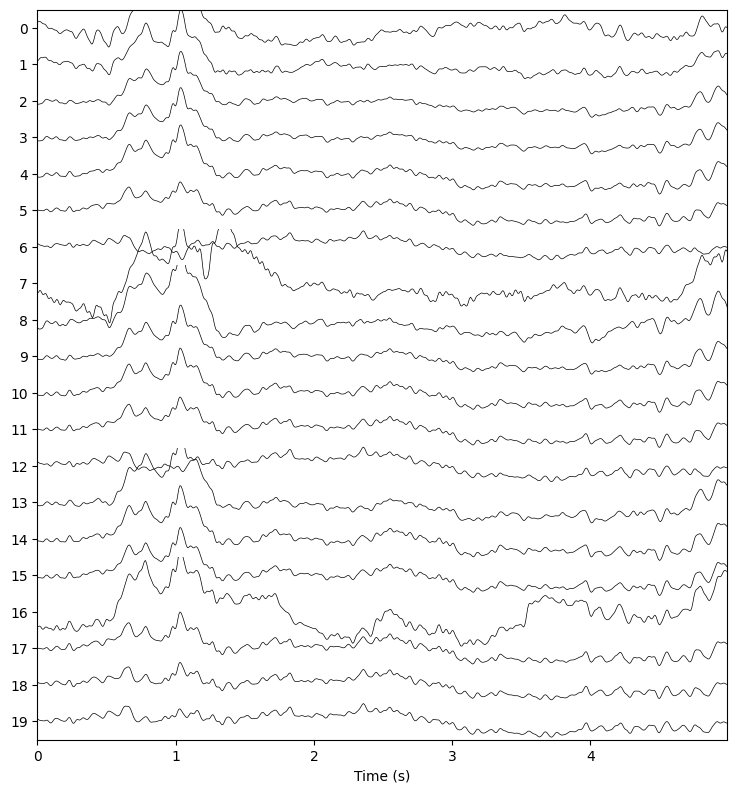

In [20]:
print('Length of dataset', len(dataset))
print('X dim', dataset[0][0].shape)
print('Y', dataset[0][1])
eeg_utils.plot_raw_eeg(dataset[5][0])

In [23]:
model = Wav2VecBrainModel()
task = MaskedContrastiveLearningTask(dataset, 
        task_params={
            'mask_prob': config.mask_prob
        },
        train_params={
            'num_epochs': config.epochs,
            'batch_size': config.batch_size,
            'print_every': 100
        }
)
trained_model = task.train(model)

Training on  cuda
Epoch 0, Iteration 0, loss = 3.7844
Epoch 0, Iteration 100, loss = nan
Epoch 0, Iteration 200, loss = nan


KeyboardInterrupt: 